In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [25]:
df = pd.read_csv('smart_synthetic_network_data_10years.csv')

In [26]:
df.head(100)

,Time,Connected Clients,Chipset Temp,Supply Voltage,Packet Loss,Network Congestion,Jitter,RSSI,SNR,Temperature,Humidity
0,01-01-2013 00:00,22.48,18.05,3.307,1.36,42.90,6.83,-52.73,22.92,19.26,77.29
1,01-01-2013 01:00,19.32,18.91,3.299,2.18,40.70,3.75,-51.31,23.18,18.25,73.91
2,01-01-2013 02:00,23.26,25.18,3.295,1.53,35.45,2.93,-52.89,21.34,20.77,68.02
3,01-01-2013 03:00,27.65,26.74,3.297,2.40,43.87,4.79,-57.01,25.68,21.08,74.74
4,01-01-2013 04:00,18.88,21.10,3.287,2.47,37.68,5.73,-52.53,23.71,18.50,81.26
...,...,...,...,...,...,...,...,...,...,...,...
95,01-04-2013 23:00,13.84,26.31,3.313,2.02,39.30,7.32,-52.86,19.74,23.92,82.63
96,01-05-2013 00:00,22.65,14.39,3.261,2.10,43.93,7.21,-53.64,23.34,17.11,78.10
97,01-05-2013 01:00,22.49,17.40,3.313,1.77,42.89,7.37,-49.55,25.41,18.62,79.65
98,01-05-2013 02:00,21.22,20.10,3.291,2.87,48.95,7.31,-55.64,29.83,19.87,78.85


In [27]:
# health_status = []

# for _, row in df.iterrows():
#     if (
#         row["Chipset_Temp"] < 40 and
#         row["Supply_Voltage"] > 2.4 and
#         row["Packet_Loss"] <= 5 and
#         row["Network_Congestion"] <=40 and
#         row["Jitter"] < 50 and
#         row["RSSI"] > -90 and
#         row["SNR"] > 20 and
#         20 <= row["Humidity"] <= 90 and
#         0 <= row["Temperature"] <= 45
#     ):
#         health_status.append(1)
#     else:
#         health_status.append(0)

# df['Health_Status'] = health_status

In [28]:
# df['Health_Status'] = (
#     (df["Chipset_Temp"] < 40) &
#     (df["Supply_Voltage"] > 2.4) &
#     (df["Packet_Loss"] <= 5) &
#     (df["Network_Congestion"] <= 40)&
#     (df["Jitter"] < 50) &
#     (df["RSSI"] > -90) &
#     (df["SNR"] > 20) &
#     (df["Humidity"].between(20, 90)) &
#     (df["Temperature"].between(0, 45))
# ).astype(int)

In [29]:
print(df.columns)

Index(['Time', 'Connected Clients', 'Chipset Temp', 'Supply Voltage',
       'Packet Loss', 'Network Congestion', 'Jitter', 'RSSI', 'SNR',
       'Temperature', 'Humidity'],
      dtype='object')


In [30]:
#Drop non-feature/time-based columns
df_cleaned = df.drop(columns=['Time'])

Feature Scaling

In [31]:
# Standardization (Z-score)
standard_scaler = StandardScaler()
df_standard_scaled = pd.DataFrame(standard_scaler.fit_transform(df_cleaned), columns=df_cleaned.columns)



In [32]:
# Normalization (Min-Max)
minmax_scaler = MinMaxScaler()
df_minmax_scaled = pd.DataFrame(minmax_scaler.fit_transform(df_cleaned), columns=df_cleaned.columns)



Outlier Removal using IQR on standardized data

In [33]:
# Compute IQR
Q1 = df_standard_scaled.quantile(0.25)
Q3 = df_standard_scaled.quantile(0.75)
IQR = Q3 - Q1

# Filter out rows with any outlier in any column
df_no_outliers = df_standard_scaled[~((df_standard_scaled < (Q1 - 1.5 * IQR)) | 
                                      (df_standard_scaled > (Q3 + 1.5 * IQR))).any(axis=1)]

# Optional: Print shapes to compare
print("Original shape:", df_standard_scaled.shape)
print("After outlier removal:", df_no_outliers.shape)

Original shape: (87600, 10)
After outlier removal: (86322, 10)


In [34]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


In [37]:
# Add a simple binary target for HEALTH prediction
df_no_outliers['Health'] = (
    (df_no_outliers['Chipset Temp'] < 40) & 
    (df_no_outliers['Supply Voltage'] > 0) & 
    (df_no_outliers['Packet Loss'] < 2) &
    (df["Network Congestion"] <= 40)&
     (df["Jitter"] < 50) &
     (df["RSSI"] > -90) &
     (df["SNR"] > 20) &
     (df["Humidity"].between(20, 60)) &
     (df["Temperature"].between(0, 45))
).astype(int)

C:\Users\PRIYANSHU BARDHAN\AppData\Local\Temp\ipykernel_13296\2508930740.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_outliers['Health'] = (


In [38]:
df_no_outliers.head()

,Connected Clients,Chipset Temp,Supply Voltage,Packet Loss,Network Congestion,Jitter,RSSI,SNR,Temperature,Humidity,Health
0,-1.715790,-1.891135,0.353290,-0.712437,0.192384,0.915545,1.630761,-0.449995,-0.100917,1.153712,0
1,-1.740830,-1.858441,-0.046188,0.202735,0.045936,-0.622482,1.740218,-0.393914,-0.238361,0.928404,0
2,-1.709609,-1.620080,-0.245927,-0.522706,-0.303543,-1.031957,1.618428,-0.790799,0.104568,0.535782,0
3,-1.674822,-1.560775,-0.146057,0.448269,0.256955,-0.103148,1.300848,0.145332,0.146753,0.983731,0
4,-1.744317,-1.775186,-0.645405,0.526393,-0.155097,0.366250,1.646177,-0.279594,-0.204340,1.418348,0


In [39]:
# Split features and target
X = df_no_outliers.drop(columns=['Health'])
y = df_no_outliers['Health']

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=42)


In [40]:
from scipy.stats import skew

# Example: Compute skewness for each numeric column
skewness_values = df_no_outliers.skew(numeric_only=True)
print(skewness_values)

Connected Clients    -0.000009
Chipset Temp         -0.002194
Supply Voltage       -0.006270
Packet Loss           0.021693
Network Congestion   -0.000208
Jitter                0.004703
RSSI                  0.001577
SNR                   0.002453
Temperature          -0.000096
Humidity             -0.001782
Health                3.022455
dtype: float64


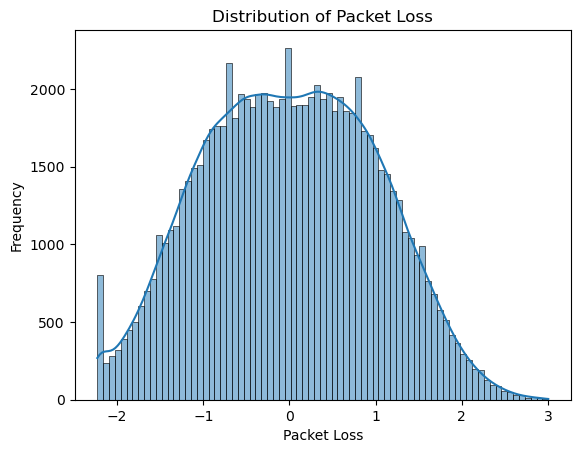

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt

# Example for one column
column = 'Packet Loss'  # change this to any numeric column
sns.histplot(df_no_outliers[column], kde=True)
plt.title(f'Distribution of {column}')
plt.xlabel(column)
plt.ylabel('Frequency')
plt.show()

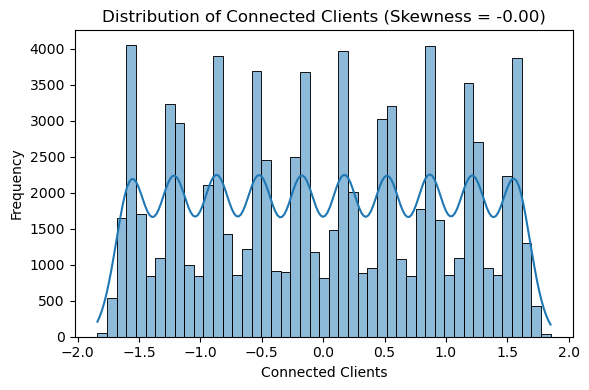

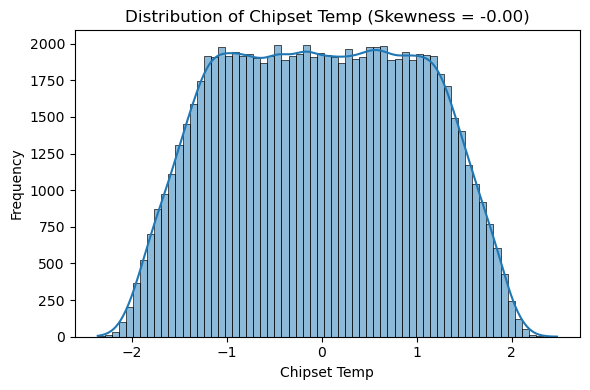

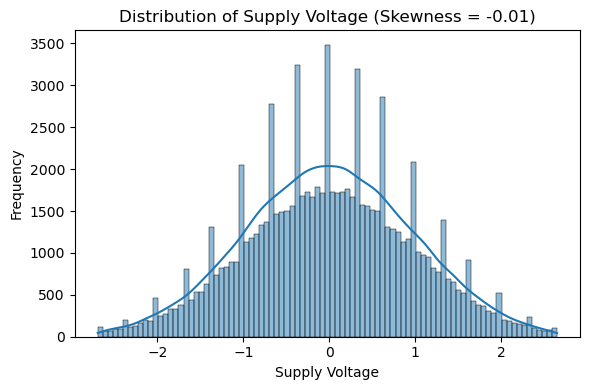

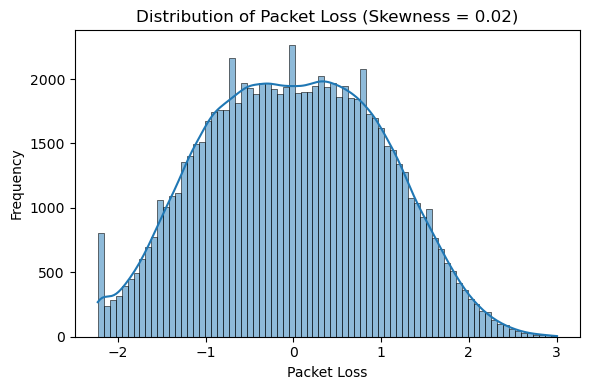

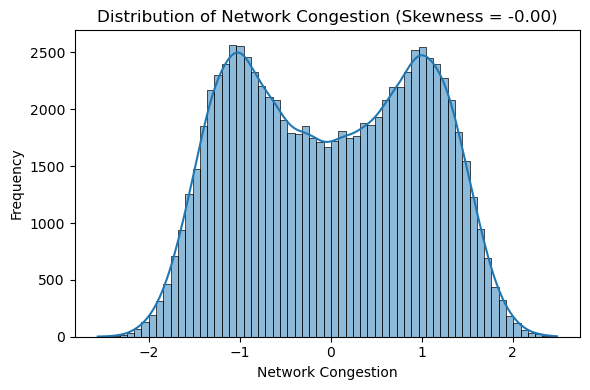

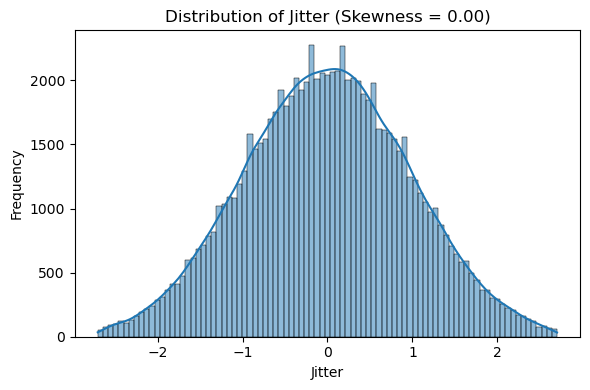

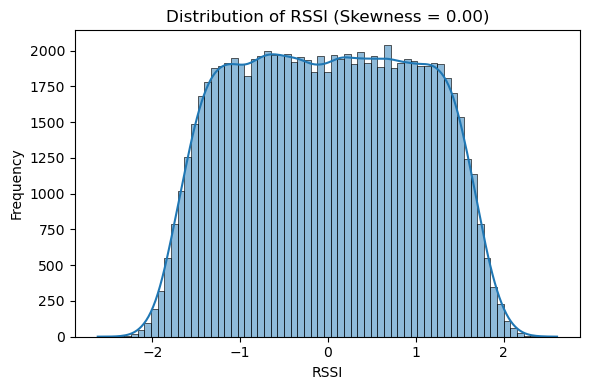

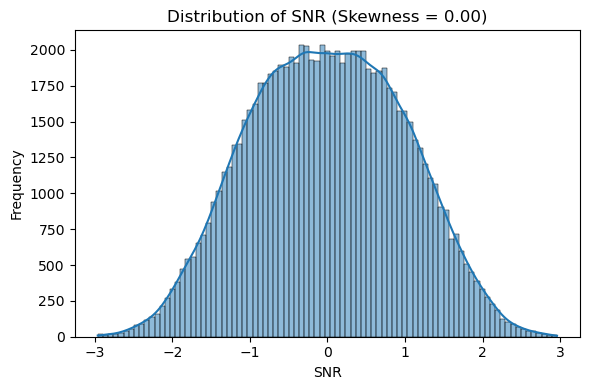

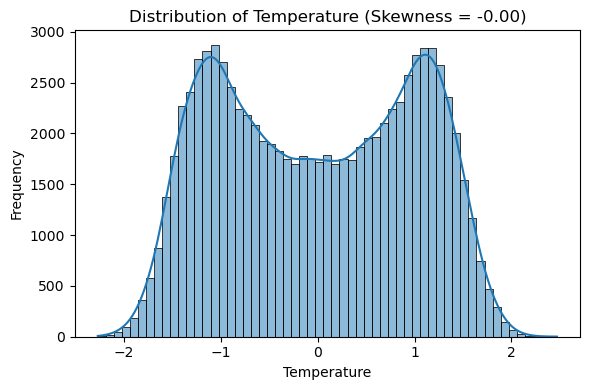

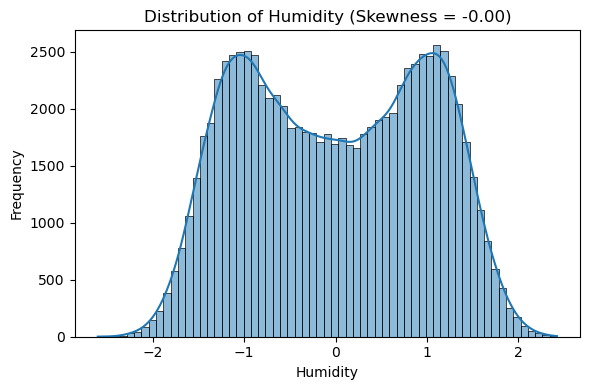

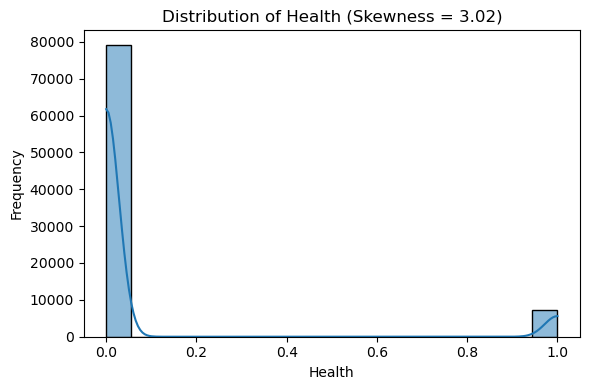

In [42]:
numeric_cols = df_no_outliers.select_dtypes(include='number').columns

for col in numeric_cols:
    plt.figure(figsize=(6, 4))
    sns.histplot(df_no_outliers[col], kde=True)
    plt.title(f'Distribution of {col} (Skewness = {df_no_outliers[col].skew():.2f})')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

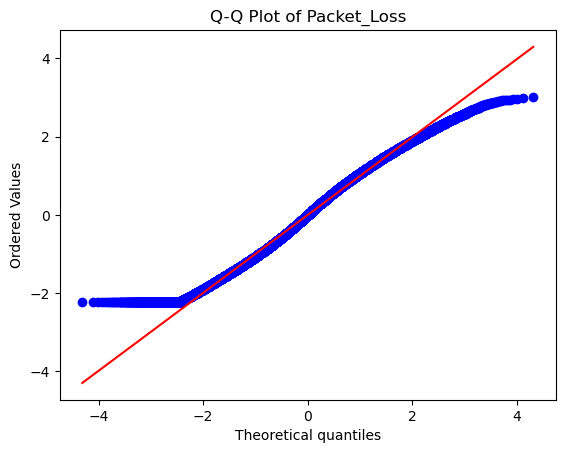

In [52]:
import scipy.stats as stats
import matplotlib.pyplot as plt

stats.probplot(df_no_outliers['Packet Loss'], dist="norm", plot=plt)
plt.title("Q-Q Plot of Packet_Loss")
plt.show()

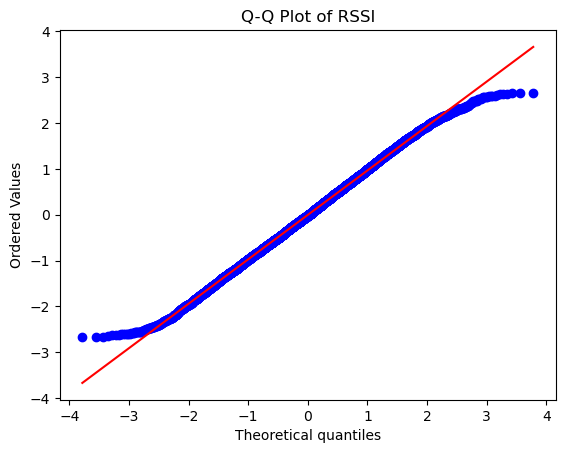

In [ ]:
import scipy.stats as stats
import matplotlib.pyplot as plt

stats.probplot(df_no_outliers['RSSI'], dist="norm", plot=plt)
plt.title("Q-Q Plot of RSSI")
plt.show()

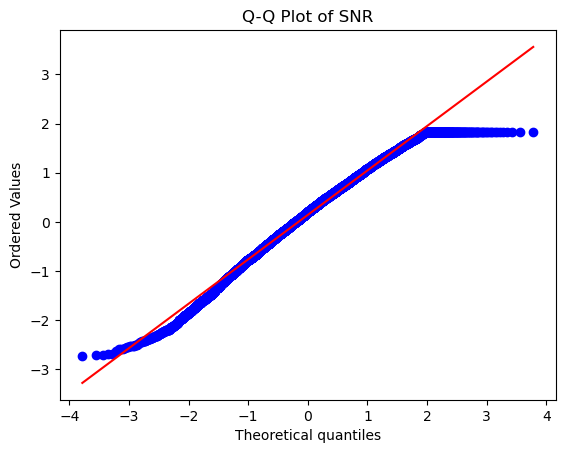

In [ ]:
import scipy.stats as stats
import matplotlib.pyplot as plt

stats.probplot(df_no_outliers['SNR'], dist="norm", plot=plt)
plt.title("Q-Q Plot of SNR")
plt.show()

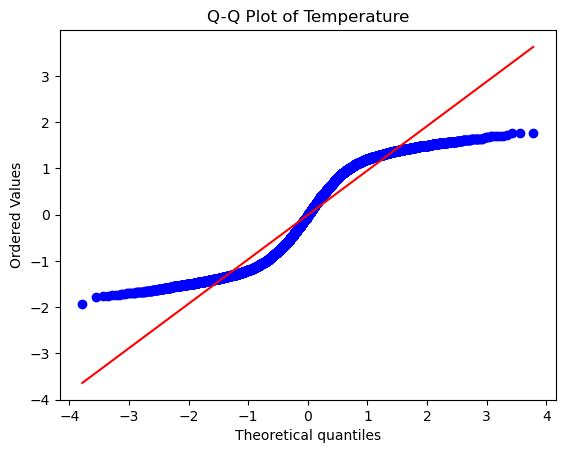

In [ ]:
import scipy.stats as stats
import matplotlib.pyplot as plt

stats.probplot(df_no_outliers['Temperature'], dist="norm", plot=plt)
plt.title("Q-Q Plot of Temperature")
plt.show()

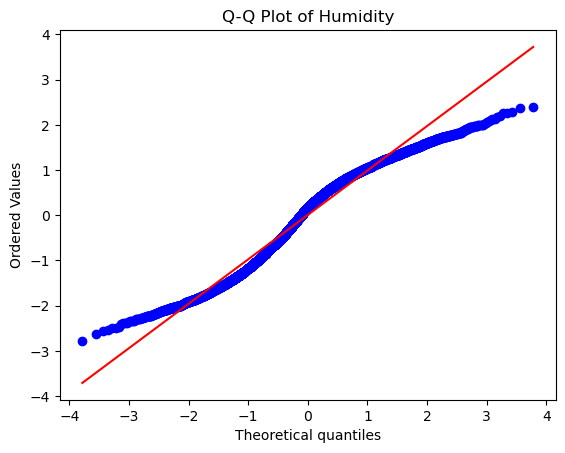

In [ ]:
import scipy.stats as stats
import matplotlib.pyplot as plt

stats.probplot(df_no_outliers['Humidity'], dist="norm", plot=plt)
plt.title("Q-Q Plot of Humidity")
plt.show()

In [46]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression

# Train model
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

# Predict
y_pred_lr = log_reg.predict(X_test)

# Evaluate
print("Logistic Regression Report:")
print(classification_report(y_test, y_pred_lr))

# Test Accuracy
accuracy = accuracy_score(y_test, y_pred_lr)
print(f"Test Accuracy: {accuracy:.4f}")


Logistic Regression Report:
              precision    recall  f1-score   support

           0       0.95      0.98      0.96     63334
           1       0.65      0.45      0.54      5724

    accuracy                           0.93     69058
   macro avg       0.80      0.72      0.75     69058
weighted avg       0.93      0.93      0.93     69058

Test Accuracy: 0.9347


In [47]:
from sklearn.ensemble import RandomForestClassifier

# Train model
rf = RandomForestClassifier(n_estimators=100, random_state=30)
rf.fit(X_train, y_train)

# Predict and evaluate
y_pred_rf = rf.predict(X_test)
print("Random Forest Report:")
print(classification_report(y_test, y_pred_rf))


Random Forest Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     63334
           1       1.00      0.99      1.00      5724

    accuracy                           1.00     69058
   macro avg       1.00      1.00      1.00     69058
weighted avg       1.00      1.00      1.00     69058



In [48]:
from xgboost import XGBClassifier

# Train model
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)

# Predict and evaluate
y_pred_xgb = xgb.predict(X_test)
print("XGBoost Report:")
print(classification_report(y_test, y_pred_xgb))


c:\Users\PRIYANSHU BARDHAN\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:39:03] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     63334
           1       0.99      0.99      0.99      5724

    accuracy                           1.00     69058
   macro avg       1.00      1.00      1.00     69058
weighted avg       1.00      1.00      1.00     69058



In [49]:
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore



# Separate features and target
X = df_no_outliers.drop(columns=['Health'])
y = df_no_outliers['Health']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Remove outliers using Z-score method
z_scores = zscore(X_scaled)
abs_z_scores = abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
X_no_outliers = X_scaled[filtered_entries]
y_no_outliers = y[filtered_entries]

X_no_outliers.shape, y_no_outliers.shape


((86321, 10), (86321,))

In [50]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X_no_outliers, y_no_outliers, test_size=0.2, random_state=42)

# Initialize models
log_reg = LogisticRegression(max_iter=1000)
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Train models
log_reg.fit(X_train, y_train)
rf_clf.fit(X_train, y_train)
xgb_clf.fit(X_train, y_train)

# Predictions
log_pred = log_reg.predict(X_test)
rf_pred = rf_clf.predict(X_test)
xgb_pred = xgb_clf.predict(X_test)

# Evaluation
log_report = classification_report(y_test, log_pred, output_dict=True)
rf_report = classification_report(y_test, rf_pred, output_dict=True)
xgb_report = classification_report(y_test, xgb_pred, output_dict=True)

log_report, rf_report, xgb_report


c:\Users\PRIYANSHU BARDHAN\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:39:53] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


({'0': {'precision': 0.9505386875612145,
   'recall': 0.9802411463922732,
   'f1-score': 0.9651614507256736,
   'support': 15841.0},
  '1': {'precision': 0.6630785791173305,
   'recall': 0.43258426966292135,
   'f1-score': 0.5235869103272418,
   'support': 1424.0},
  'accuracy': 0.9350709527946713,
  'macro avg': {'precision': 0.8068086333392726,
   'recall': 0.7064127080275973,
   'f1-score': 0.7443741805264577,
   'support': 17265.0},
  'weighted avg': {'precision': 0.9268292641946295,
   'recall': 0.9350709527946713,
   'f1-score': 0.928740822545693,
   'support': 17265.0}},
 {'0': {'precision': 0.9999368766569877,
   'recall': 1.0,
   'f1-score': 0.9999684373323232,
   'support': 15841.0},
  '1': {'precision': 1.0,
   'recall': 0.9992977528089888,
   'f1-score': 0.9996487530734106,
   'support': 1424.0},
  'accuracy': 0.9999420793512888,
  'macro avg': {'precision': 0.9999684383284939,
   'recall': 0.9996488764044944,
   'f1-score': 0.9998085952028669,
   'support': 17265.0},
  'we

In [51]:
# Convert classification reports to readable format
import pandas as pd

log_report_df = pd.DataFrame(log_report).transpose()
rf_report_df = pd.DataFrame(rf_report).transpose()

log_report_df[['precision', 'recall', 'f1-score']], rf_report_df[['precision', 'recall', 'f1-score']]


(              precision    recall  f1-score
 0              0.950539  0.980241  0.965161
 1              0.663079  0.432584  0.523587
 accuracy       0.935071  0.935071  0.935071
 macro avg      0.806809  0.706413  0.744374
 weighted avg   0.926829  0.935071  0.928741,
               precision    recall  f1-score
 0              0.999937  1.000000  0.999968
 1              1.000000  0.999298  0.999649
 accuracy       0.999942  0.999942  0.999942
 macro avg      0.999968  0.999649  0.999809
 weighted avg   0.999942  0.999942  0.999942)